# ADTA 5550 Final Project PART III
## Trisa Nguyen
## July 25, 2022

In [1]:
## Import libraries

import matplotlib.pyplot as plt 
%matplotlib inline

from matplotlib import pyplot as plt

import pandas as pd
import numpy as np

import tensorflow as tf

### Load Data

In [2]:
# Set path for dataset

CIFAR_DIR = '/home/thnguyen5550/JPTR_NTBK/CIFAR_10_DATA/'

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [4]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

all_data = [0,1,2,3,4,5,6]

for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(CIFAR_DIR+direc)

In [5]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [6]:
batch_meta

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [7]:
data_batch1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

### Display single images using matplotlib

In [8]:
X = data_batch1[b"data"] 

In [9]:
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")


In [10]:
X[0].max()

255

In [11]:
(X[0]/255).max()

1.0

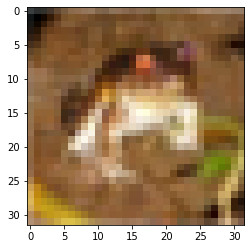

In [12]:
plt.imshow(X[0])

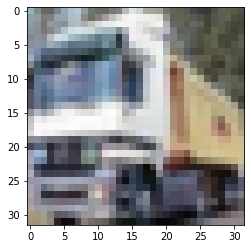

In [13]:
plt.imshow(X[1])

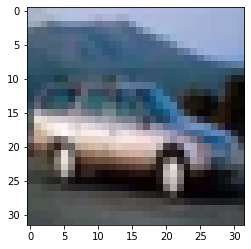

In [14]:
plt.imshow(X[4])

### Encode Labels

In [15]:
def one_hot_encode(vec, vals=10):

    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

### Prepare Image Data to be fed into 1st Convolution Layer

In [16]:
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        self.test_batch = [test_batch]
        
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)

        
    def next_batch(self, batch_size):
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

### Prepare image data: Calling CifarHelper.set_up_images()

In [17]:
# Before Your tf.Session run these two lines
ch = CifarHelper()
ch.set_up_images()

# During your session to grab the next batch use this line
# (Just like we did for mnist.train.next_batch)
# batch = ch.next_batch(100)

Setting Up Training Images and Labels
Setting Up Test Images and Labels


### Define Supporting Functions to Build, Train, and Test CNN Model

In [18]:
# This function returns a tf.Variable used to store weights in a filter
# This variable is initialized with values that can be used to initialize weights 
# The values are random numbers

def initialize_weights(filter_shape):
    
    init_random_dist = tf.truncated_normal(filter_shape,stddev=0.1)
    
    return (tf.Variable(init_random_dist))

In [19]:
# This function returns a tf.Variable used to store bias
# This variable is initialized with values that can be usedto initialized bias
# The value is initialized to 0.1

def initialize_bias(bias_shape):
    
    initial_bias_vals = tf.constant(0.1,shape=bias_shape)
    
    return (tf.Variable(initial_bias_vals))

### Setup 1st Convolution Layer and Perform Convolution Computation: Dot Product (x*W)

In [20]:
def create_convolution_layer_and_compute_dot_product (inputs, filter_shape):
    #Initialize the weights in the filter
    filter_initialized_with_weights = initialize_weights(filter_shape)
    
    #Create a Convolution Layer
    conv_layer_outputs = tf.nn.conv2d(inputs,filter_initialized_with_weights, strides=[1,1,1,1],padding ='SAME')
    
    #Return the convolution layer outputs
    return (conv_layer_outputs)

### Setup ReLU Layer and Perform Convolution Computation: Dot Product (x*W)

In [21]:
def create_relu_layer_and_compute_dotproduct_plus_b(inputs, filter_shape):
    
    #Initialize bias for each input channel
    b = initialize_bias([filter_shape[3]])
    
    # Perform the computation first by adding: inputs (x * W) + b
    # Create a RelU layer associated with the preceding convolution layer
    relu_layer_outputs = tf.nn.relu(inputs+b)
    
    # Return the outputs of the ReLU layer
    return (relu_layer_outputs)

In [22]:
def conv2d(inputs, filter_shape):
    filter_initialized_with_weights = initialize_weights(filter_shape)
    conv_layer_outputs = tf.nn.conv2d(inputs,filter_initialized_with_weights, strides=[1,1,1,1],padding ='SAME')
    conv2d_output=conv_layer_outputs
    
    #Adding bias to the dot product
    b = initialize_bias([filter_shape[3]])
    
    #Relu activation function
    relu_layer_outputs = tf.nn.relu(conv2d_output+b)
    
    #Max polling layer to extract features from image
    pooling_layer_outputs = tf.nn.max_pool(relu_layer_outputs, ksize=[1,2,2,1],strides = [1,2,2,1],padding='SAME')
    return pooling_layer_outputs

### Setup 1st Pooling Layer and Reduce Spatial Size

In [23]:
def create_max_pool(inputs):
    
    #Create a pooling layer
    pooling_layer_outputs = tf.nn.max_pool(inputs, ksize=[1,2,2,1],strides = [1,2,2,1],padding='SAME')
    
    # Return the pooling Layer
    return (pooling_layer_outputs)

### Setup Fully Connected (FC) Layer and Perform Computation: (Inputs*Weights)+Bias

In [24]:
def create_fully_connected_layer_and_compute_dotproduct_plus_bias (inputs, output_size):
    
    #Get the number of input channels from the input
    #Inputs: the outputs fro  the preceding Layer or previous operation like reshaping 
    input_size = int(inputs.get_shape()[1])
    
    #Initialize the weights of the filter of the FC layer
    # Filter shape [in_channels, out_channels]
    # Each weight for one filter cell
    W = initialize_weights([input_size, output_size])
    
    #Initialize the bias: each bias, one output channel
    b = initialize_bias([output_size])
    
    #Perform the computation for FC layer and then add bias to get the result
    fcbias_outputs=tf.matmul(inputs,W)+b
    
    # Return the results: outputs
    return (fcbias_outputs)

## PHASE I: Build Convolutional Neural Network

### Create Placeholders for Inputs and Labels: x and y_true

In [25]:
# PLACEHOLDER

# Create a placeholder for the inputs data: x
# x: a 2D array
# x: a placeholder that can hold any number of rows/record

x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])

In [26]:
# PLACEHOLDER

# Create a placeholder for the labels of the inputs data: y_true
# y_true: a 2D array
# y_true: Can hold any number of rows/records

y_true = tf.placeholder(tf.float32, [None, 10])

### Reshape Input Placeholder x 

In [27]:
# DO NOTHING -- DON'T NEED TO RESHAPE - DATA IS ALREADY IN GOOD SHAPE TO BE FED INTO 1ST CONVOLUTION LAYER


In [28]:
## Create 1st Convolution Layer

In [29]:
#Create a first convolution layer
conv_layer1=create_convolution_layer_and_compute_dot_product(x,filter_shape=[5, 5, 3, 32])

In [30]:
## Create the ReLU layer for the 1st convolution layer

In [31]:
# Accept the outputs from the 1st conv layer as the inputs
# Perform the computation at the layer and rfeturn the output to the layer

conv_relu_layer1=create_relu_layer_and_compute_dotproduct_plus_b(conv_layer1,filter_shape=[5,5,3,32])

### Create 1st pooling layer and reduce spatial size

In [32]:
pooling_layer1 = create_max_pool(conv_relu_layer1)

In [33]:
## Create 2nd Convolution Layer, ReLU Layer, and Perform Computation: (x*w)+b

In [34]:
# Create a 2nd convolutional layer
conv_layer2=create_convolution_layer_and_compute_dot_product(pooling_layer1,filter_shape=[5,5,32,64])

In [35]:
# Create the ReLU layer for the 2nd convolution layer
conv_relu_layer2=create_relu_layer_and_compute_dotproduct_plus_b(conv_layer2,filter_shape=[5,5,32,64])

In [36]:
## Create 2nd Pooling Layer and Reduce Spatial Size

In [37]:
pooling_layer2 = create_max_pool(conv_relu_layer2)

### Reshape/Flatten Data to Feed into 1st FC Layer

In [38]:
# Reshape and flatten the output of the 3rd pooling layer
# Prepare to feed the output data into the 1st fully connected layer

pooling_layer2_flatten = tf.reshape(pooling_layer2, [-1,8*8*64])

### Create 1st FC Layer, ReLU layer, and Output Data to Dropout Layer

In [39]:
# First, Create the FC (fully connected) layer
fc_layer_1_outputs = create_fully_connected_layer_and_compute_dotproduct_plus_bias(pooling_layer2_flatten, output_size=1024)

In [40]:
# Create the ReLU layer of the 1st FC layer
fc_relu_layer_1_outputs = tf.nn.relu(fc_layer_1_outputs)

### Create Dropout layer and dropout a fraction of outputs randomly

In [41]:
dropout_hold_prob = tf.placeholder(tf.float32)
dropout_outputs = tf.nn.dropout(fc_relu_layer_1_outputs, keep_prob=dropout_hold_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Create Final FC Layer, Compute (x*W)+b, and Produce Final Outputs

In [42]:
y_pred = create_fully_connected_layer_and_compute_dotproduct_plus_bias(dropout_outputs,output_size=10)

### Define Loss Function and Calculation Softmax Cross Entropy Loss

In [43]:
softmax_cross_entropy_loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,logits=y_pred)
cross_entropy_mean = tf.reduce_mean(softmax_cross_entropy_loss)


### Create an Optimizer to Optimize CNN Model and Set Learning Rate

In [44]:
# Get an ADAM optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

### Create a trainer to train CNN Model

In [45]:
# Create a CNN model trainer that can train the model
# And optimize the model by minimizing the softmax cross_entropy loss

cnn_trainer=optimizer.minimize(cross_entropy_mean)

## PHASE II: Train and Test CNN Model on CIFAR-10 Dataset

### Train and Test CNN Deep learning model 

### Create a Variable initializer to Initialize all Variables

In [46]:
vars_initializer = tf.global_variables_initializer()
steps=5000

### Run tf.Sessions() to Train and Test Deep Learning CNN Model

In [47]:
with tf.Session() as sess:
    sess.run(vars_initializer)
    accuracy=[]
    steps_i=[]
    for i in range(steps):
        batch_x,batch_y = ch.next_batch(100)
        sess.run(cnn_trainer,feed_dict = 
                {x:batch_x, y_true:batch_y,dropout_hold_prob:0.5})
        if i%100==0:
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
            acc = tf.reduce_mean(tf.cast(matches,tf.float32))
            test_accuracy = sess.run(acc, feed_dict = 
                {x:ch.test_images,y_true:ch.test_labels,dropout_hold_prob:1.0})
            accuracy.append(test_accuracy)
            steps_i.append(i)
            
            print("ON STEP :",i , " Accuracy :",test_accuracy)
            print("\n")


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   OMP_NUM_THREADS=8

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_HAND_THREAD=false
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_FORKJOIN_FRAMES=true
   KMP_FORKJOIN_FRAMES_MODE=3
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_ITT_PREPARE_DELAY=0
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_MWAIT_HINTS=0
   KMP_NUM_LOCKS_IN_BLOCK=1

ON STEP : 0  Accuracy : 0.0994


ON STEP : 100  Accuracy : 0.4208


ON STEP : 200  Accuracy : 0.4497


ON STEP : 300  Accuracy : 0.4999


ON STEP : 400  Accuracy : 0.5141


ON STEP : 500  Accuracy : 0.5385


ON STEP : 600  Accuracy : 0.5607


ON STEP : 700  Accuracy : 0.5768


ON STEP : 800  Accuracy : 0.5764


ON STEP : 900  Accuracy : 0.585


ON STEP : 1000  Accuracy : 0.6113


ON STEP : 1100  Accuracy : 0.6212


ON STEP : 1200  Accuracy : 0.6263


ON STEP : 1300  Accuracy : 0.6204


ON STEP : 1400  Accuracy : 0.6306


ON STEP : 1500  Accuracy : 0.6346


ON STEP : 1600  Accuracy : 0.6464


ON STEP : 1700  Accuracy : 0.6426


ON STEP : 1800  Accuracy : 0.6429


ON STEP : 1900  Accuracy : 0.6562


ON STEP : 2000  Accuracy : 0.6491


ON STEP : 2100  Accuracy : 0.654


ON STEP : 2200  Accuracy : 0.6748


ON STEP : 2300  Accuracy : 0.6659


ON STEP : 2400  Accuracy : 0.6742


ON STEP : 2500  Accuracy : 0.6686


ON STEP : 2600  Accuracy : 0.6653


ON STEP : 2700  Accuracy : 0.6832


ON STE

In [48]:
print(f"Test Accuracy Mean: {round(np.mean(accuracy)*100,2)}")

Test Accuracy Mean: 62.92


Text(0, 0.5, 'Accuracy')

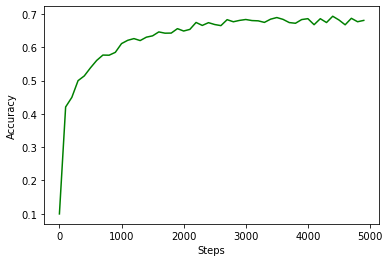

In [49]:
plt.plot(steps_i,accuracy, label='train acc',color='g',)
plt.xlabel("Steps")
plt.ylabel("Accuracy")

In [50]:
ACC_cnn_cifar_10=pd.DataFrame(list(zip(steps_i,accuracy)))

In [51]:
ACC_cnn_cifar_10=ACC_cnn_cifar_10.rename(columns={0:"Step_Size",1:"Test_Accuracy"})


In [52]:
ACC_cnn_cifar_10.to_csv("ACC_cnn_cifar_10.csv")
